In [27]:
# import necessary modules

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from feature_engine.outliers import Winsorizer
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

from scipy import stats


Set up a connection to a cloud-based database using Python. We used a zip file named 'secure-connect-ml-projects.zip', which contains all the necessary configuration settings. The PlainTextAuthProvider uses security credentials for the connection. After establishing the connection, we sent a query to the database to get the release version of the system. The version was then printed out, confirming that our connection and query execution were successful.

In [28]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

cloud_config= {
    'secure_connect_bundle': 'D:\secure-connect-ml-projects.zip'
}
auth_provider = PlainTextAuthProvider('ylHAUuutJalGrfaMhsAGyYGS', 'UrdCS4S7jOrnzxgmhazNOx2fRs4tly0E1Kynx6kdQZpUszkCZTTSkuli4-JA.Dx6sp7HT-XqUwAP2Eh1MDhov5KO.5ABJiTc7PRzWe++fEhQG3s8ZlJlhvGtqqXu,Fdg')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
    print(row[0])
else:
    print("An error occurred.")


4.0.0.6816


In [29]:
tables = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name='concrete_strength_prediction'")
for table in tables:
    print(table.table_name)


concrete_data


In [30]:
# check the rows in database

query = "SELECT COUNT(*) FROM concrete_strength_prediction.concrete_data"
rows = session.execute(query)

for row in rows:
    print(row)

Row(count=990)


In [31]:
# load data in dataframe 

query = "SELECT * FROM concrete_strength_prediction.concrete_data"

rows = session.execute(query)

df = pd.DataFrame(list(rows))

df.head(5)

,cement,concrete_compressive_strength,age,blast_furnace_slag,coarse_aggregate,fine_aggregate,fly_ash,superplasticizer,water
0,182,21.5,14,45.2,1059.4,780.7,122,8.2,170.2
1,237.5,26.26,7,237.5,932,594,0,0,228
2,212.5,26.31,14,0,1007.8,903.6,100.4,8.7,159.3
3,307,36.15,365,0,968,812,0,0,193
4,168,39.23,100,42.1,1058.7,780.1,163.8,5.7,121.8


#### EDA done in pervious notebook

In [32]:
# drop duplicate rows

df = df.drop_duplicates()

In [33]:
# make copy of df for further invistegition 

df1= df.copy()
df2 = df.copy()

In [34]:
df.dtypes

cement                           object
concrete_compressive_strength    object
age                               int64
blast_furnace_slag               object
coarse_aggregate                 object
fine_aggregate                   object
fly_ash                          object
superplasticizer                 object
water                            object
dtype: object

In [35]:
# change object features to float

columns_to_convert = ['cement', 'concrete_compressive_strength', 'blast_furnace_slag', 'coarse_aggregate', 'fine_aggregate', 'fly_ash', 'superplasticizer', 'water']

for column in columns_to_convert:
    df[column] = df[column].astype(float)


In [36]:
df.dtypes

cement                           float64
concrete_compressive_strength    float64
age                                int64
blast_furnace_slag               float64
coarse_aggregate                 float64
fine_aggregate                   float64
fly_ash                          float64
superplasticizer                 float64
water                            float64
dtype: object

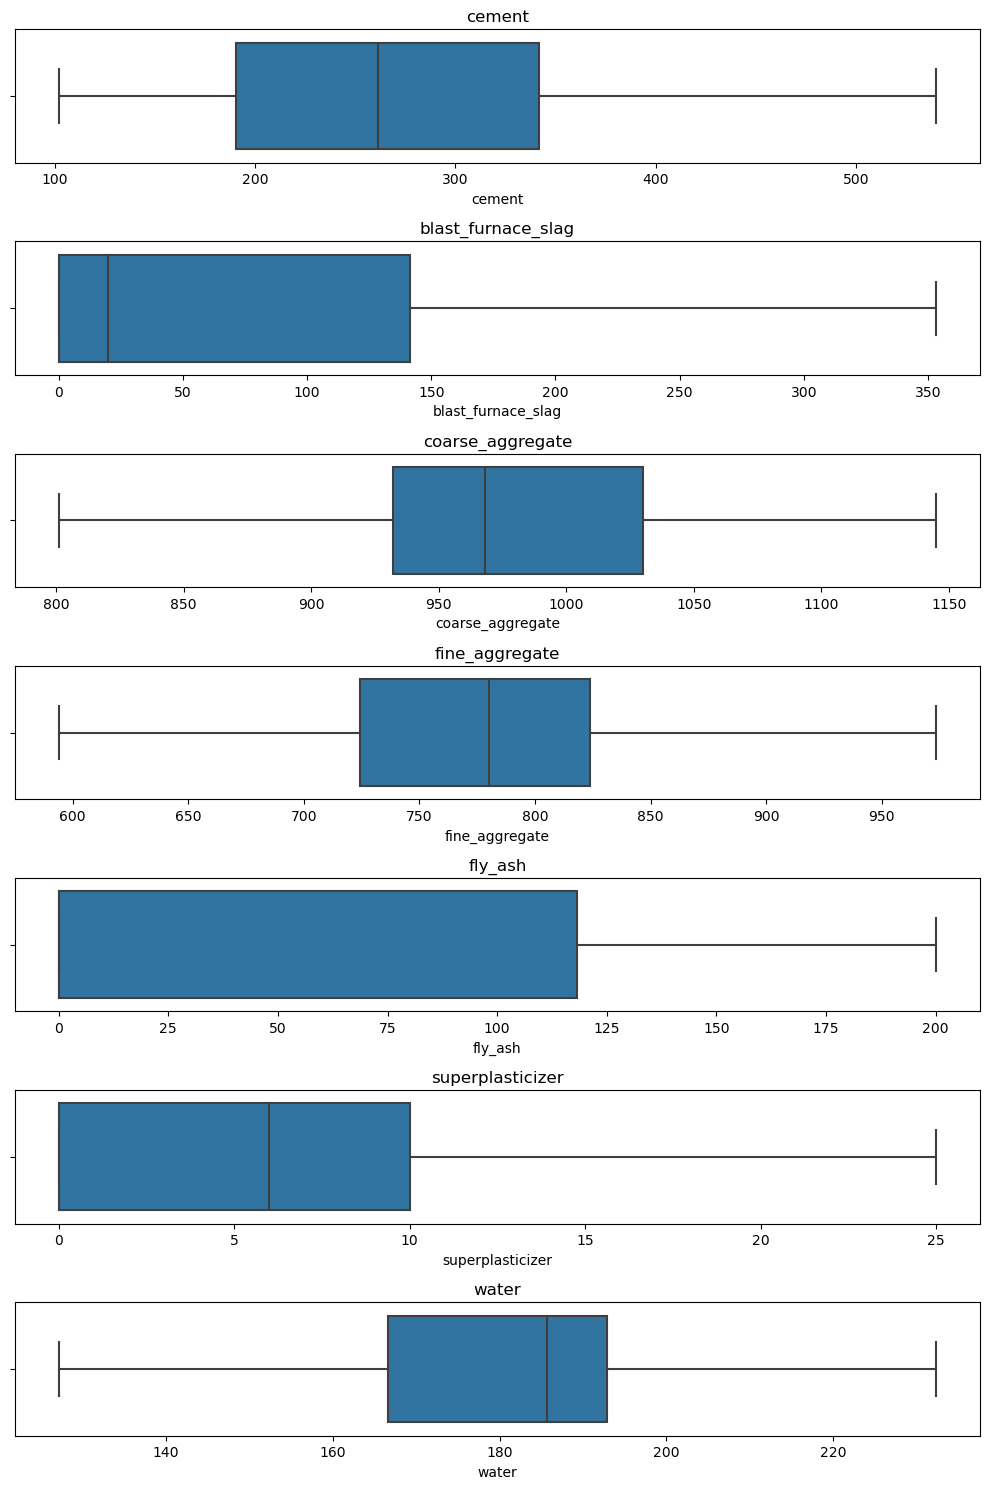

In [37]:
from feature_engine.outliers import Winsorizer

# Select the features to apply Winsorization
features = ['cement', 'blast_furnace_slag', 'coarse_aggregate', 'fine_aggregate', 'fly_ash', 'superplasticizer', 'water']

# Create the Winsorizer transformer
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=features)

# Fit and transform the data
df[features] = winsorizer.fit_transform(df[features])

# Set the size of the figure
plt.figure(figsize=(10, 15))

# For each feature, create a subplot and draw a boxplot
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.boxplot(x=df[feature])
    plt.title(feature)

# Display the plot
plt.tight_layout()
plt.show()

In [38]:
"""features = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']

# Apply log transformation
df[features] = np.log1p(df[features])

num_plots = len(features)
num_rows = num_plots // 3 + num_plots % 3

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 6 * num_rows))

for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(df[feature], kde=True, ax=ax)
    skewness = stats.skew(df[feature])
    ax.set_title(f"Distribution of {feature}, skew = {skewness:.2f}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

# Remove any unused subplots
if num_plots % 3 != 0:
    for j in range(num_plots % 3, 3):
        fig.delaxes(axes[num_rows - 1, j])

plt.tight_layout()
plt.show()"""

'features = [\'cement\', \'blast_furnace_slag\', \'fly_ash\', \'water\', \'superplasticizer\', \'coarse_aggregate\', \'fine_aggregate\', \'age\']\n\n# Apply log transformation\ndf[features] = np.log1p(df[features])\n\nnum_plots = len(features)\nnum_rows = num_plots // 3 + num_plots % 3\n\nfig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 6 * num_rows))\n\nfor i, feature in enumerate(features):\n    row = i // 3\n    col = i % 3\n    ax = axes[row, col]\n    sns.histplot(df[feature], kde=True, ax=ax)\n    skewness = stats.skew(df[feature])\n    ax.set_title(f"Distribution of {feature}, skew = {skewness:.2f}")\n    ax.set_xlabel(feature)\n    ax.set_ylabel("Density")\n\n# Remove any unused subplots\nif num_plots % 3 != 0:\n    for j in range(num_plots % 3, 3):\n        fig.delaxes(axes[num_rows - 1, j])\n\nplt.tight_layout()\nplt.show()'

In [39]:
# train test split

X = df.drop(['concrete_compressive_strength'], axis=1)
y = df['concrete_compressive_strength']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

In [40]:
#XG boost

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)



# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_ypred_train = xgb_model.predict(X_train)
xgb_ypred_test = xgb_model.predict(X_test)

# Calculate metrics
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_ypred_test))
xgb_r2_train = r2_score(y_train, xgb_ypred_train)
xgb_r2_test = r2_score(y_test, xgb_ypred_test)

# Perform  k fold cross-validation on XGBoost Regression
k = 5 
kfold_XG = KFold(n_splits=k, random_state= 42, shuffle=True)
CV_score_XG = cross_val_score(xgb_model,X,y, scoring='r2', cv=kfold_XG)



print("XGBoost Regression (Train) - R^2:", xgb_r2_train)
print("XGBoost Regression (Test) - R^2:", xgb_r2_test)
print("XGBoost Regression (Test) - RMSE:", xgb_rmse_test)
print("XGBoost Regression CV Score :", CV_score_XG.mean())

XGBoost Regression (Train) - R^2: 0.9978543852441253
XGBoost Regression (Test) - R^2: 0.8905013507596263
XGBoost Regression (Test) - RMSE: 5.279523711010611
XGBoost Regression CV Score : 0.9279878687407728


In [41]:
X.columns

Index(['cement', 'age', 'blast_furnace_slag', 'coarse_aggregate',
       'fine_aggregate', 'fly_ash', 'superplasticizer', 'water'],
      dtype='object')

In [42]:
"""#Hyperparamater tuning
#Grid serch 

from sklearn.model_selection import GridSearchCV

# Define a parameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'lambda': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'n_estimators': [50,100,200,300,400,500],
    'max_depth': [2, 4, 6]
}

# Initialize an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameter
print(grid_search.best_params_)"""

"#Hyperparamater tuning\n#Grid serch \n\nfrom sklearn.model_selection import GridSearchCV\n\n# Define a parameter grid\nparam_grid = {\n    'alpha': [0.001, 0.01, 0.1, 1, 10],\n    'lambda': [0.001, 0.01, 0.1, 1, 10],\n    'gamma': [0.001, 0.01, 0.1, 1, 10],\n    'n_estimators': [50,100,200,300,400,500],\n    'max_depth': [2, 4, 6]\n}\n\n# Initialize an XGBoost Regressor\nxgb_model = xgb.XGBRegressor(objective='reg:squarederror')\n\n# Initialize the GridSearchCV object\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameter\nprint(grid_search.best_params_)"

XGBoost Regression (Train) - R^2: 0.9838304229655298
XGBoost Regression (Test) - R^2: 0.92107852537034
XGBoost Regression (Test) - RMSE: 4.482166232997484
XGBoost Regression CV Score : 0.9247607803419495


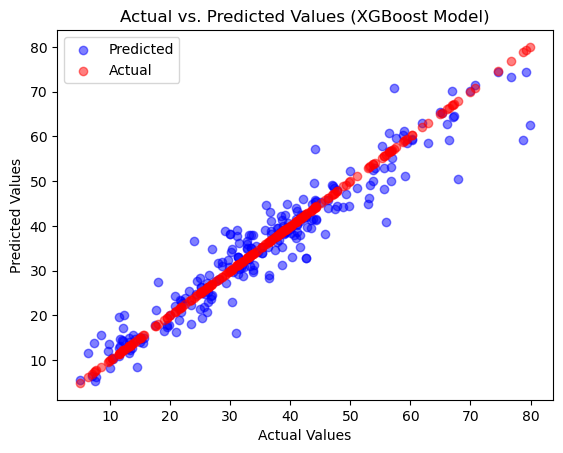

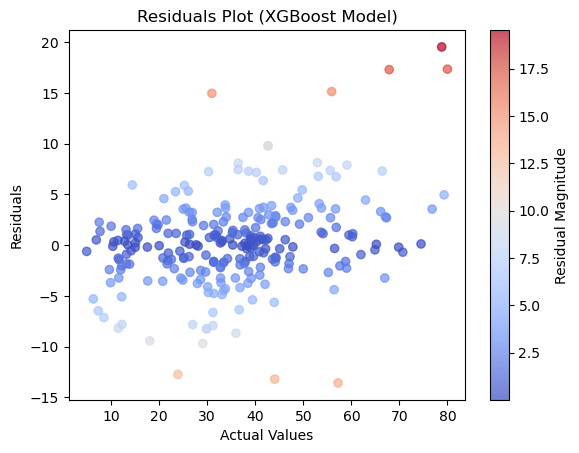

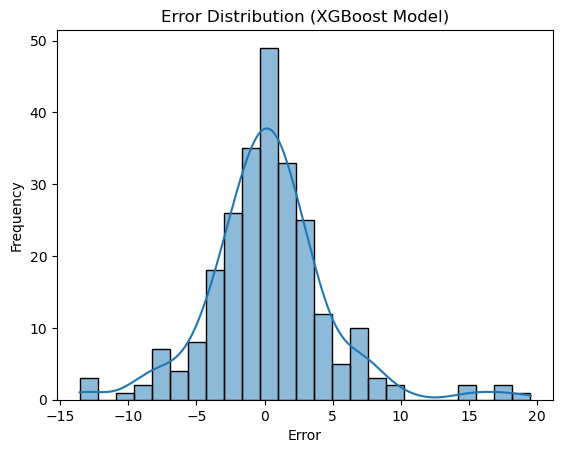

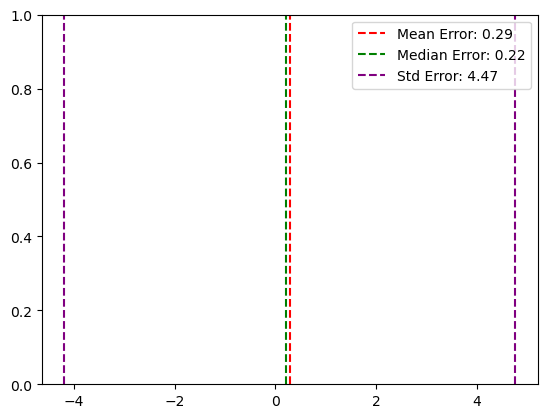

In [43]:
#XG boost remodeling

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, reg_alpha=0.1, reg_lambda=10, gamma=0.01, max_depth=4)


# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_ypred_train = xgb_model.predict(X_train)
xgb_ypred_test = xgb_model.predict(X_test)

# Calculate metrics
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_ypred_test))
xgb_r2_train = r2_score(y_train, xgb_ypred_train)
xgb_r2_test = r2_score(y_test, xgb_ypred_test)

# Perform  k fold cross-validation on XGBoost Regression
k = 5 
kfold_XG = KFold(n_splits=k, random_state= 42, shuffle=True)
CV_score_XG = cross_val_score(xgb_model,X,y, scoring='r2', cv=kfold_XG)



print("XGBoost Regression (Train) - R^2:", xgb_r2_train)
print("XGBoost Regression (Test) - R^2:", xgb_r2_test)
print("XGBoost Regression (Test) - RMSE:", xgb_rmse_test)
print("XGBoost Regression CV Score :", CV_score_XG.mean())


# Scatter plot for actual vs. predicted values on test set
plt.scatter(y_test, xgb_ypred_test, c='b', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='r', label='Actual', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (XGBoost Model)")
plt.legend()
plt.show()


# Calculate residuals
residuals = y_test - xgb_ypred_test

# Define colors for bubbles based on the magnitude of residuals
colors = np.abs(residuals)

# Scatter plot for residuals
plt.scatter(y_test, residuals, c=colors, cmap='coolwarm', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (XGBoost Model)")
plt.colorbar(label='Residual Magnitude')
plt.show()

# Error distribution plot
sns.histplot(residuals, kde=True)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (XGBoost Model)")
plt.show()

# Calculate central tendency
mean_error = np.mean(residuals)
median_error = np.median(residuals)

# Calculate spread
std_error = np.std(residuals)

# Display statistics
plt.axvline(mean_error, color='red', linestyle='--', label=f"Mean Error: {mean_error:.2f}")
plt.axvline(median_error, color='green', linestyle='--', label=f"Median Error: {median_error:.2f}")
plt.axvline(mean_error + std_error, color='purple', linestyle='--', label=f"Std Error: {std_error:.2f}")
plt.axvline(mean_error - std_error, color='purple', linestyle='--')

plt.legend()
plt.show()

Hybrid Model (Train) - R^2: 0.9855403013823855
Hybrid Model (Test) - R^2: 0.9209579255524434
Hybrid Model (Test) - RMSE: 4.485589522341612
Hybrid Model CV Score: 0.9290649185166207


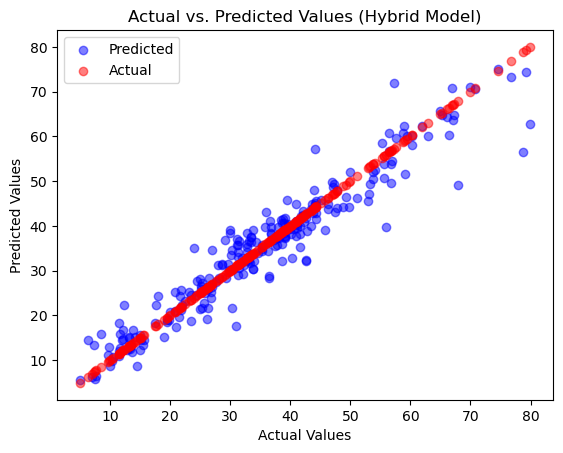

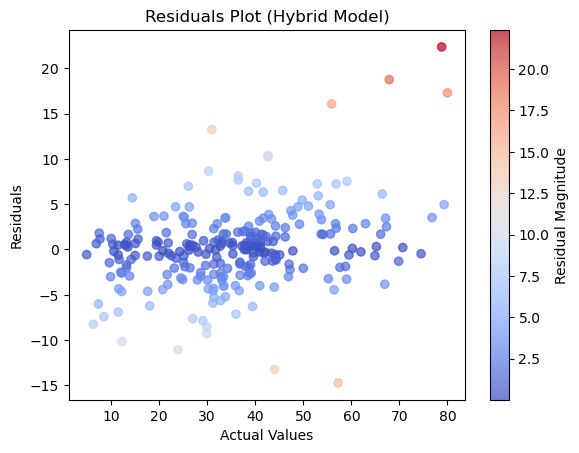

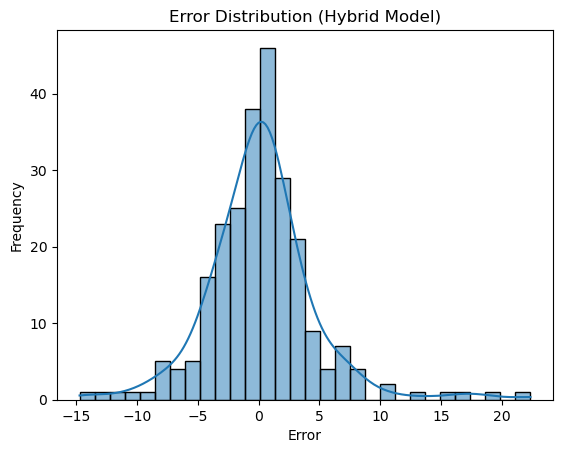

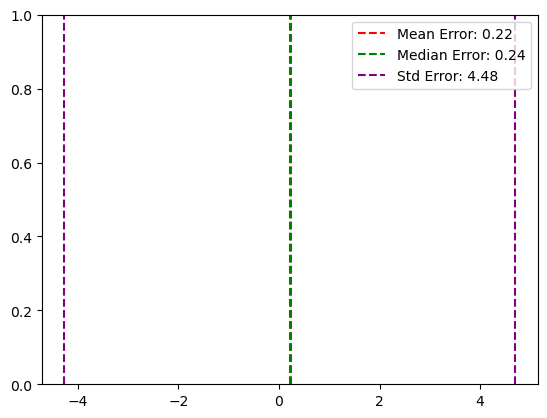

In [51]:

#{'boosting_type': 'gbdt', 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_data_in_leaf': 10, 'min_split_gain': 0.01, 'n_estimators': 300, 
 #'num_leaves': 31, 'objective': 'regression', 'random_state': 501, 'subsample': 0.5


# XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, reg_alpha=0.1, reg_lambda=10, gamma=0.01, max_depth=4)

# Fit the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions with XGBoost
xgb_ypred_train = xgb_model.predict(X_train)
xgb_ypred_test = xgb_model.predict(X_test)

# LightGBM model
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    colsample_bytree=0.5,
    learning_rate=0.1,
    max_depth=4,
    min_data_in_leaf=10,
    min_split_gain=0.01,
    n_estimators=300,
    num_leaves=31,
    objective='regression',
    random_state=501,
    subsample=0.5)

# Fit the LightGBM model
lgb_model.fit(X_train, y_train)

# Make predictions with LightGBM
lgb_ypred_train = lgb_model.predict(X_train)
lgb_ypred_test = lgb_model.predict(X_test)

# Combine predictions
hybrid_ypred_train = (xgb_ypred_train + lgb_ypred_train) / 2
hybrid_ypred_test = (xgb_ypred_test + lgb_ypred_test) / 2

# Calculate metrics for hybrid model
hybrid_rmse_test = np.sqrt(mean_squared_error(y_test, hybrid_ypred_test))
hybrid_r2_train = r2_score(y_train, hybrid_ypred_train)
hybrid_r2_test = r2_score(y_test, hybrid_ypred_test)

# Perform k-fold cross-validation on the hybrid model
k = 10
kfold_hybrid = KFold(n_splits=k, random_state=42, shuffle=True)
CV_scores_hybrid = cross_val_score(xgb_model, X, y, scoring='r2', cv=kfold_hybrid)

# Print metrics for the hybrid model
print("Hybrid Model (Train) - R^2:", hybrid_r2_train)
print("Hybrid Model (Test) - R^2:", hybrid_r2_test)
print("Hybrid Model (Test) - RMSE:", hybrid_rmse_test)
print("Hybrid Model CV Score:", CV_scores_hybrid.mean())


# Scatter plot for actual vs. predicted values on test set
plt.scatter(y_test, hybrid_ypred_test, c='b', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='r', label='Actual', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Hybrid Model)")
plt.legend()
plt.show()

# Calculate residuals
residuals = y_test - hybrid_ypred_test

# Define colors for bubbles based on the magnitude of residuals
colors = np.abs(residuals)

# Scatter plot for residuals
plt.scatter(y_test, residuals, c=colors, cmap='coolwarm', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Hybrid Model)")
plt.colorbar(label='Residual Magnitude')
plt.show()




errors = y_test - hybrid_ypred_test

# Error distribution plot
sns.histplot(errors, kde=True)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (Hybrid Model)")
plt.show()

# Calculate central tendency
mean_error = np.mean(errors)
median_error = np.median(errors)

# Calculate spread
std_error = np.std(errors)

# Display statistics
plt.axvline(mean_error, color='red', linestyle='--', label=f"Mean Error: {mean_error:.2f}")
plt.axvline(median_error, color='green', linestyle='--', label=f"Median Error: {median_error:.2f}")
plt.axvline(mean_error + std_error, color='purple', linestyle='--', label=f"Std Error: {std_error:.2f}")
plt.axvline(mean_error - std_error, color='purple', linestyle='--')

plt.legend()
plt.show()

In [50]:
""" from sklearn.model_selection import GridSearchCV

lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'boosting_type' : ['gbdt', 'dart'],
    'objective' : ['regression'],
    'random_state' : [501], 
    'colsample_bytree' : [0.5, 0.7],
    'subsample' : [0.5, 0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
}

lgb_grid_search = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)
lgb_grid_search.fit(X_train, y_train)

# Get the best parameters
lgb_best_params = lgb_grid_search.best_params_

print(lgb_best_params)"""





Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
{'boosting_type': 'gbdt', 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_data_in_leaf': 10, 'min_split_gain': 0.01, 'n_estimators': 300, 'num_leaves': 31, 'objective': 'regression', 'random_state': 501, 'subsample': 0.5}


0:	learn: 15.6816962	total: 1.06ms	remaining: 105ms
1:	learn: 14.7687510	total: 2.04ms	remaining: 99.9ms
2:	learn: 13.9756163	total: 2.69ms	remaining: 87ms
3:	learn: 13.3111578	total: 3.34ms	remaining: 80.3ms
4:	learn: 12.7078311	total: 4.03ms	remaining: 76.6ms
5:	learn: 12.1284905	total: 4.74ms	remaining: 74.2ms
6:	learn: 11.6150555	total: 5.4ms	remaining: 71.8ms
7:	learn: 11.2552633	total: 6.19ms	remaining: 71.2ms
8:	learn: 10.8367425	total: 6.87ms	remaining: 69.4ms
9:	learn: 10.4039429	total: 7.57ms	remaining: 68.1ms
10:	learn: 10.1630325	total: 8.25ms	remaining: 66.7ms
11:	learn: 9.7898602	total: 9.14ms	remaining: 67ms
12:	learn: 9.4544031	total: 9.88ms	remaining: 66.1ms
13:	learn: 9.1374765	total: 10.5ms	remaining: 64.8ms
14:	learn: 8.8527962	total: 11.3ms	remaining: 63.8ms
15:	learn: 8.6475659	total: 11.9ms	remaining: 62.5ms
16:	learn: 8.4109485	total: 12.6ms	remaining: 61.3ms
17:	learn: 8.2301848	total: 13.2ms	remaining: 60.2ms
18:	learn: 8.0546435	total: 13.9ms	remaining: 59.2m

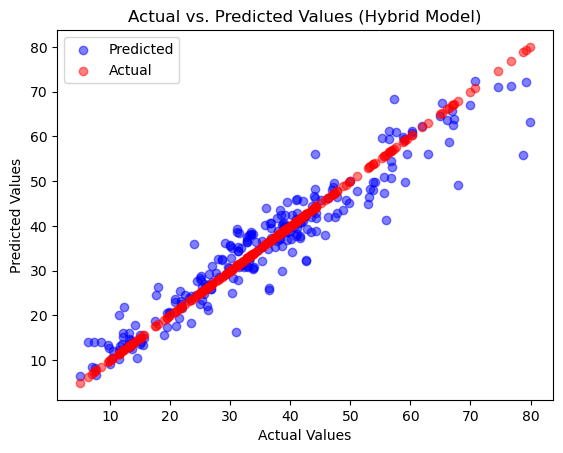

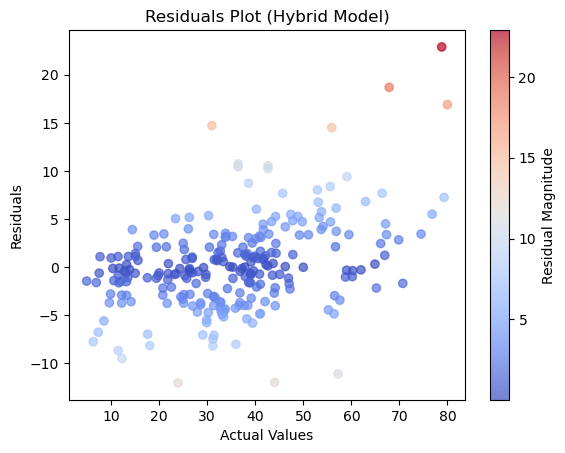

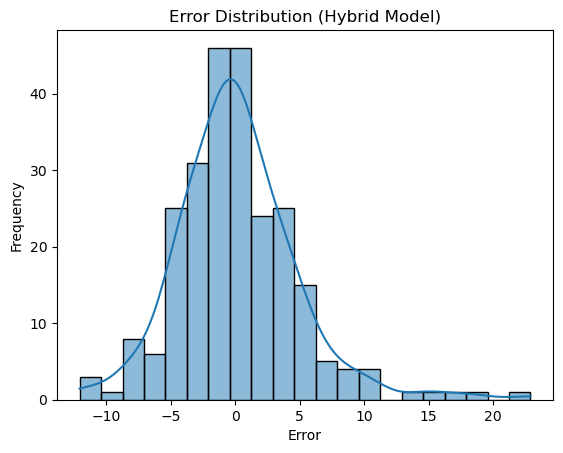

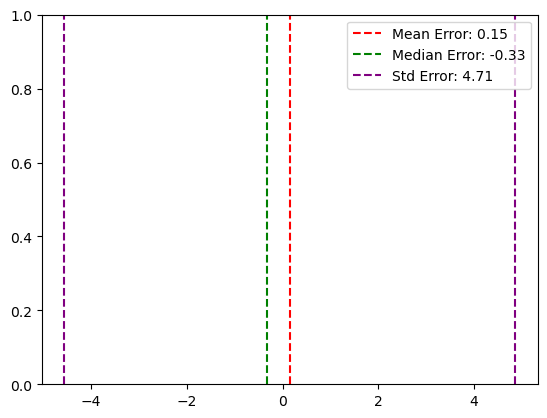

In [48]:
from catboost import CatBoostRegressor

# XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, reg_alpha=0.1, reg_lambda=10, gamma=0.01, max_depth=4)

# Fit the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions with XGBoost
xgb_ypred_train = xgb_model.predict(X_train)
xgb_ypred_test = xgb_model.predict(X_test)

# CatBoost model
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=4, random_state=42)

# Fit the CatBoost model
catboost_model.fit(X_train, y_train)

# Make predictions with CatBoost
catboost_ypred_train = catboost_model.predict(X_train)
catboost_ypred_test = catboost_model.predict(X_test)

# Combine predictions
hybrid_ypred_train = (xgb_ypred_train + catboost_ypred_train) / 2
hybrid_ypred_test = (xgb_ypred_test + catboost_ypred_test) / 2

# Calculate metrics for hybrid model
hybrid_rmse_test = np.sqrt(mean_squared_error(y_test, hybrid_ypred_test))
hybrid_r2_train = r2_score(y_train, hybrid_ypred_train)
hybrid_r2_test = r2_score(y_test, hybrid_ypred_test)

# Perform k-fold cross-validation on the hybrid model
k = 10
kfold_hybrid = KFold(n_splits=k, random_state=42, shuffle=True)
CV_scores_hybrid = cross_val_score(xgb_model, X, y, scoring='r2', cv=kfold_hybrid)

# Print metrics for the hybrid model
print("Hybrid Model (Train) - R^2:", hybrid_r2_train)
print("Hybrid Model (Test) - R^2:", hybrid_r2_test)
print("Hybrid Model (Test) - RMSE:", hybrid_rmse_test)
print("Hybrid Model CV Score:", CV_scores_hybrid.mean())


# Scatter plot for actual vs. predicted values on test set
plt.scatter(y_test, hybrid_ypred_test, c='b', label='Predicted', alpha=0.5)
plt.scatter(y_test, y_test, c='r', label='Actual', alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Hybrid Model)")
plt.legend()
plt.show()

# Calculate residuals
residuals = y_test - hybrid_ypred_test

# Define colors for bubbles based on the magnitude of residuals
colors = np.abs(residuals)

# Scatter plot for residuals
plt.scatter(y_test, residuals, c=colors, cmap='coolwarm', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Hybrid Model)")
plt.colorbar(label='Residual Magnitude')
plt.show()




errors = y_test - hybrid_ypred_test

# Error distribution plot
sns.histplot(errors, kde=True)
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution (Hybrid Model)")
plt.show()

# Calculate central tendency
mean_error = np.mean(errors)
median_error = np.median(errors)

# Calculate spread
std_error = np.std(errors)

# Display statistics
plt.axvline(mean_error, color='red', linestyle='--', label=f"Mean Error: {mean_error:.2f}")
plt.axvline(median_error, color='green', linestyle='--', label=f"Median Error: {median_error:.2f}")
plt.axvline(mean_error + std_error, color='purple', linestyle='--', label=f"Std Error: {std_error:.2f}")
plt.axvline(mean_error - std_error, color='purple', linestyle='--')

plt.legend()
plt.show()

In [46]:
 """#save model

import pickle

filename = 'final_model.sav'
pickle.dump(xgb_model, open(filename,'wb')) """



"#save model\n\nimport pickle\n\nfilename = 'final_model.sav'\npickle.dump(xgb_model, open(filename,'wb')) "

In [47]:
"""#loding the save model

loaded_model = pickle.load(open('final_model.sav', 'rb')) """

"#loding the save model\n\nloaded_model = pickle.load(open('final_model.sav', 'rb')) "